<a href="https://colab.research.google.com/github/Akash12-sudo/Skin_disease_detection/blob/main/Skin_Disease_Detection_DL_Updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Activation, Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU') 
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
## Connecting to the google drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Unzipping the zipped folder containing dataset
import zipfile
dataset_ref = zipfile.ZipFile('/content/drive/MyDrive/project_data.zip')
dataset_ref.extractall('/content')
dataset_ref.close()

In [6]:
# Data Processing Step
train_dir = '/content/project_data/train'
test_dir = '/content/project_data/test'
num_classes = 4

## Data augmentation technique to prevent overfitting
# training dataset generator 
train_datagen = ImageDataGenerator(        
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split = 0.2  # set aside 10% of training data for validation
)

# testing dataset generator
test_datagen = ImageDataGenerator(
    rescale = 1./255
)

### Loading the dataset
# training dataset
train_ds = train_datagen.flow_from_directory(
    train_dir, 
    target_size = (256, 256),
    class_mode = "categorical",
    batch_size = 32,
    subset = "training"
)

# validation dataset
val_ds = train_datagen.flow_from_directory(
    train_dir, 
    target_size = (256, 256),
    class_mode = "categorical",
    subset = "validation"
)

# test dataset
test_ds = test_datagen.flow_from_directory(
    test_dir,
    target_size = (256, 256),
    class_mode = "categorical"
)



Found 3449 images belonging to 4 classes.
Found 861 images belonging to 4 classes.
Found 1181 images belonging to 4 classes.


In [7]:
# Importing the Inception-V3 model
from keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (256, 256, 3))

87910968/87910968 [==============================] - 1s 0us/step


In [8]:
# Connecting with inception-v3 model
model = Sequential()
model.add(base_model)
model.add(Flatten())

model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation = 'sigmoid'))

for layer in base_model.layers:
  layer.trainable = False

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dense (Dense)               (None, 1024)              75498496  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 2

In [9]:
model.load_weights('/content/drive/MyDrive/BestModels/model-15-0.57.hdf5')

In [10]:
model.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [12]:
file_path = '/content/best_models/model-{epoch:02d}-{val_accuracy:.2f}.hdf5'

In [13]:
checkpoint = ModelCheckpoint(file_path, monitor = "val_accuracy", verbose = 1, save_best_only=True, mode = "max")

In [14]:
hist = model.fit(train_ds, validation_data = val_ds, epochs = 50, callbacks = [checkpoint])

Epoch 1/50
108/108 [==============================] - ETA: 0s - loss: 0.9660 - accuracy: 0.6129
Epoch 1: val_accuracy improved from -inf to 0.55517, saving model to /content/best_models/model-01-0.56.hdf5
108/108 [==============================] - 115s 938ms/step - loss: 0.9660 - accuracy: 0.6129 - val_loss: 1.0787 - val_accuracy: 0.5552
Epoch 2/50
108/108 [==============================] - ETA: 0s - loss: 0.9492 - accuracy: 0.6208
Epoch 2: val_accuracy did not improve from 0.55517
108/108 [==============================] - 95s 881ms/step - loss: 0.9492 - accuracy: 0.6208 - val_loss: 1.1505 - val_accuracy: 0.5494
Epoch 3/50
108/108 [==============================] - ETA: 0s - loss: 0.9356 - accuracy: 0.6280
Epoch 3: val_accuracy improved from 0.55517 to 0.58188, saving model to /content/best_models/model-03-0.58.hdf5
108/108 [==============================] - 96s 888ms/step - loss: 0.9356 - accuracy: 0.6280 - val_loss: 1.0654 - val_accuracy: 0.5819
Epoch 4/50
108/108 [=================

In [15]:
from tensorflow.keras.metrics import Recall, Precision, Accuracy, CategoricalAccuracy

In [16]:
recall = Recall()
precision = Precision()
accuracy = Accuracy()

In [17]:
y_pred = model.predict(test_ds)

37/37 [==============================] - 13s 299ms/step


In [18]:
y_pred = np.argmax(y_pred, axis=1)

In [19]:
y_pred

array([2, 1, 1, ..., 1, 2, 0])

In [20]:
y_true = test_ds.classes

In [23]:
y_true

array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

In [21]:
recall.update_state(y_true, y_pred)
precision.update_state(y_true, y_pred)
accuracy.update_state(y_true, y_pred)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1181.0>

In [22]:
print(f'Recall: {recall.result().numpy()}\nPrecision: {precision.result().numpy()}\nAccuracy: {accuracy.result().numpy()}')

Recall: 0.6985040307044983
Precision: 0.7166469693183899
Accuracy: 0.20745131373405457


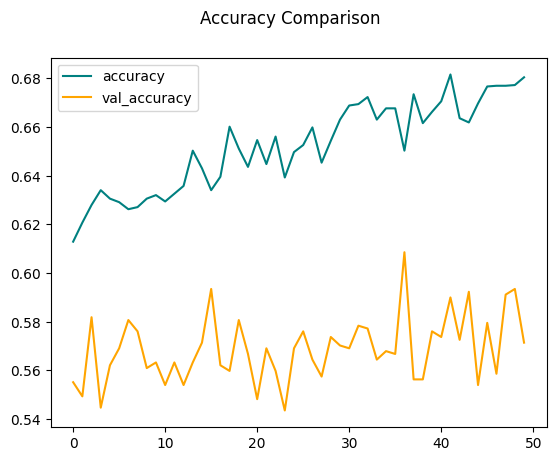

In [23]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
fig.suptitle('Accuracy Comparison')
plt.legend(loc = "upper left")
plt.show()

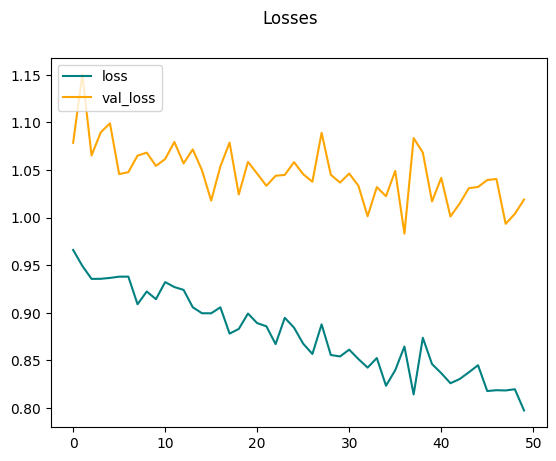

In [24]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Losses')
plt.legend(loc = "upper left")
plt.show()

In [25]:
test_loss, test_accuracy = model.evaluate(test_ds)

37/37 [==============================] - 10s 274ms/step - loss: 0.8350 - accuracy: 0.6647


In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [27]:
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

In [28]:
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

Precision: 0.2060144377197939
Recall: 0.20745131244707873
F1 score: 0.20605954916702618


In [34]:
import cv2

In [83]:
img, label = test_ds[0][0][5], test_ds[0][1][5]

[0. 0. 1. 0.]


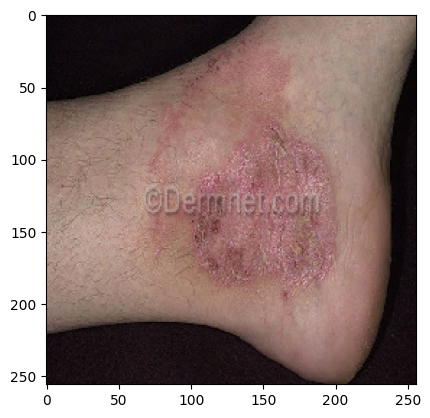

In [84]:
plt.imshow(img)
print(label)

In [85]:
img = np.expand_dims(img, axis = 0)

In [86]:
pred = model.predict(img)

1/1 [==============================] - 0s 30ms/step


In [87]:
pred

array([[0.13985127, 0.73114735, 0.9325698 , 0.56006575]], dtype=float32)

In [88]:
np.argmax(pred)

2

# **Adding the model in git repository**

In [29]:
!cp /content/best_models/model-37-0.61.hdf5 /content/drive/MyDrive/BestModels/


In [37]:
%cd /content/drive/MyDrive/BestModels/


/content/drive/MyDrive/BestModels


In [45]:
!git config user.email "akashatgml88@gmail.com"
!git config user.name "Akash12-sudo"

In [46]:
!git init

Reinitialized existing Git repository in /content/drive/MyDrive/BestModels/.git/


In [47]:
!git add .

In [48]:
!git commit -m "model-09-0.55.hdf5 commit"

On branch master
nothing to commit, working tree clean


In [54]:
!git remote set-url origin https://github.com/Akash12-sudo/Skin_disease_detection.git

In [53]:
!git log

commit 1e1e2f0583249cf7e9662f07107fcd57f085da3a (HEAD -> master)
Author: Akash12-sudo <akashatgml88@gmail.com>
Date:   Sun Apr 23 07:19:11 2023 +0000

    model-09-0.55.hdf5 commit


In [55]:
!git push -u origin master

fatal: could not read Username for 'https://github.com': No such device or address
